In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

In [4]:
tokens = np.load("tokens.npy")
print(f"dataset length: {len(tokens)} tokens")

dataset length: 5000000 tokens


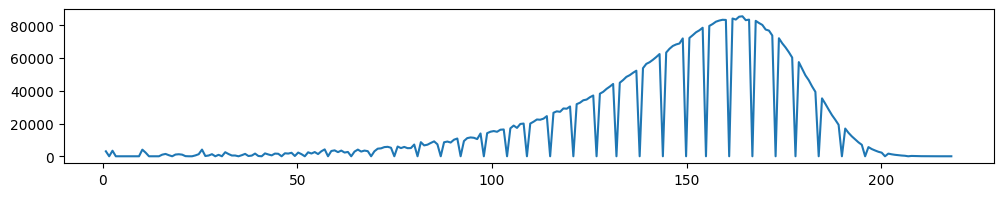

In [5]:
plt.figure(figsize=(12, 2))
counts, bins = np.histogram(tokens, bins=256)
plt.plot(bins[1:], counts)

In [6]:
print(f"number of unique tokens: {len(np.unique(tokens))}")

number of unique tokens: 207


In [8]:
import torch
dataset = torch.tensor(tokens, dtype=torch.long)

# population time
TIME_DISC = 256
population_time_log = np.linspace(3, 14, TIME_DISC)

# encode/decode
from time_discretization import discretize
encode = discretize
decode = lambda i: population_time_log[i]

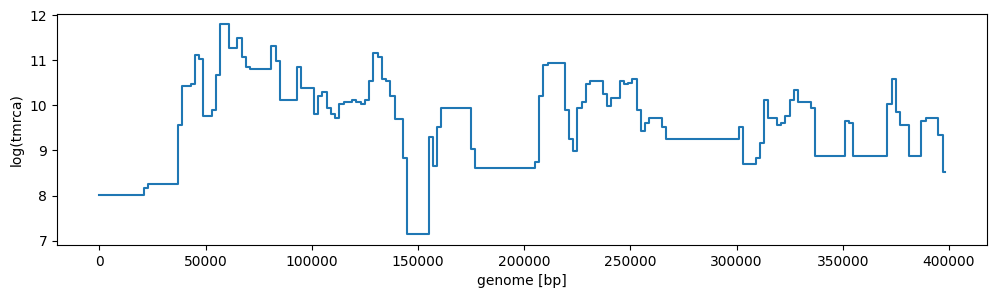

In [10]:
WINDOW_SIZE = 2000
subset = dataset[:200]
plt.figure(figsize=(12, 3))
x = np.arange(len(subset)) * WINDOW_SIZE
y = decode(subset)
sns.lineplot(x=x, y=y, drawstyle="steps-mid")
plt.ylabel("log(tmrca)")
plt.xlabel("genome [bp]")
plt.show()

In [12]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
print(f"using device {device}")

using device mps


In [14]:
# dataset reshaping

B, T = 4, 32
buf = torch.tensor(tokens[:B*T + 1])
buf = buf.to(device)
x = buf[:-1].view(B, T)
y = buf[1:].view(B, T)


In [113]:
# expected loss

-np.log(1/256)

np.float64(5.545177444479562)

In [15]:
# real loss

from model import Msprimeprime
from model import GPTConfig
model = Msprimeprime(GPTConfig())
model.to(device)
x, y = x.to(device), y.to(device)
logits, loss = model(x, y)
loss

tensor(5.6531, device='mps:0', grad_fn=<NllLossBackward0>)

In [156]:
sns.set_palette("deep")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

def plot(tmrca_input_tokens, tmrca_output_tokens, ax, title='TMRCA Distribution Across Genome'):
    x0 = np.arange(len(tmrca_input_tokens)) * WINDOW_SIZE
    x1 = np.arange(len(tmrca_output_tokens)) * WINDOW_SIZE
    x2 = np.concatenate([x0, x1])
    y0 = decode(tmrca_input_tokens)
    y1 = decode(tmrca_output_tokens)
    y2 = np.concatenate([y0, y1])

    sns.lineplot(x=x2, y=y2, drawstyle="steps-mid", linestyle="--", 
                color="#2c3e50", alpha=0.3, linewidth=1, label="Combined", ax=ax)
    sns.lineplot(x=x0, y=y0, drawstyle="steps-mid", 
                color="blue", linewidth=1.5, label="Input", ax=ax)
    ax.set_ylabel("log(TMRCA)", fontsize=12, fontweight='bold')
    plt.xlabel("Genome Position (bp)", fontsize=12, fontweight='bold')

    ax.grid(True, linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.set_ylim(3, 14)
    legend = ax.legend(frameon=True, facecolor='white', framealpha=1, loc='lower left')
    legend.get_frame().set_linewidth(0)
    if title: ax.set_title(title, fontsize=8, fontweight='bold', loc="left")

    #plt.tight_layout()

NameError: name 'plot' is not defined

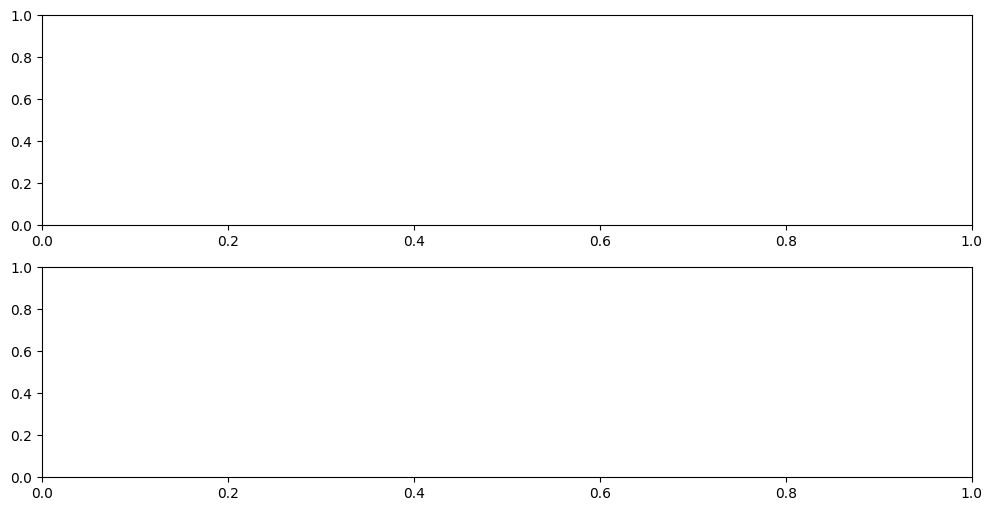

In [17]:
# untrained
model = Msprimeprime(GPTConfig())
model.to(device)

# input
size = 256
start_idx = 1000
tmrca_input_tokens = dataset[start_idx:start_idx+size][None]
tmrca_input_tokens = tmrca_input_tokens.to(device)
# output
tmrca_output_tokens = model.generate(idx=tmrca_input_tokens, max_new_tokens=500)
tmrca_output_tokens = tmrca_output_tokens.cpu()[0]
tmrca_input_tokens = tmrca_input_tokens.cpu()[0]


fig, axs = plt.subplots(2, figsize=(12, 6))
plot(tmrca_input_tokens, tmrca_output_tokens, axs[0], title='MSPRIMEPRIME (GPT2): TMRCA Distribution Across Genome (untrained)')


# trained
model = Msprimeprime(GPTConfig())
model.load_state_dict(torch.load("msprimeprime.ckpt", weights_only=True))
model.to(device)
model.eval()

size = 256
start_idx = 1000
tmrca_input_tokens = dataset[start_idx:start_idx+size][None]
tmrca_input_tokens = tmrca_input_tokens.to(device)
# output
tmrca_output_tokens = model.generate(idx=tmrca_input_tokens, max_new_tokens=500)
tmrca_output_tokens = tmrca_output_tokens.cpu()[0]
tmrca_input_tokens = tmrca_input_tokens.cpu()[0]

plot(tmrca_input_tokens, tmrca_output_tokens, axs[1], title='MSPRIMEPRIME (GPT2): TMRCA Distribution Across Genome (trained)')

plt.tight_layout()
plt.savefig("msprimeprime.png", dpi=400)
